# PROJET SEATTLE ENERGY BENCHMARKING
## Notebook 04 : Analyse multivariée - Interactions et structures cachées

---

### Identité du document

* **Statut :** Phase 1 (exploration & prototypage)
* **Date de création :** 31 Décembre 2025
* **Dernière mise à jour :** 10 Janvier 2026
* **Dépendances notebooks :** Notebooks 0, 1, 2, 3

### Description

Ce notebook est dédié à une **analyse multivariée** visant à dépasser les relations bivariées simples pour explorer la **complexité réelle** des émissions de GES.
Il adopte une posture plus **exploratoire et créative** : formuler des hypothèses métier, tester des interactions, identifier des structures latentes (segments/archétypes), et évaluer la possibilité de réduire la dimensionnalité sans perdre l’essentiel de l’information.

### Objectifs principaux

1. **Visualiser** les relations multiples simultanément (vue globale multivariée).
2. **Tester** des hypothèses d’**interactions** (effets synergiques entre variables) et sélectionner celles qui apportent un gain.
3. **Analyser** les effets **conditionnels** (une relation peut changer selon le contexte : type, quartier, époque).
4. **Identifier** des **archétypes** de bâtiments via clustering (groupes naturels aux profils d’émissions distincts).
5. **Réduire** la dimensionnalité via PCA pour comprendre la structure globale (variance expliquée, composantes).
6. **Structurer** un **blueprint de feature engineering** priorisé pour la phase de modélisation.

### Dépendances critiques

* `hydra` : Gestion de configuration (chemins, variables, paramètres d’analyse).
* `pandas`, `numpy` : Manipulation et préparation des données.
* `seaborn`, `matplotlib` : Visualisations multivariées (pairplot, FacetGrid, distributions).
* `scikit-learn` : `StandardScaler`, `KMeans`, `PCA`, métriques (silhouette), pipeline éventuel.
* `src/features/` : Fonctions pour création et traçabilité des nouvelles variables.
* `src/viz/` (optionnel) : Fonctions utilitaires de visualisation reproductible.

### LIVRABLES

1. **Notebook complété** : `notebooks/04_multivariate_full_analysis.ipynb`
2. **Interactions validées** : `reports/notebook_1/Validated_Interactions.csv`
3. **Profils de clusters** : `reports/notebook_1/Cluster_Profiles.md` (description narrative des archétypes)
4. **Blueprint Feature Engineering** : `reports/notebook_1/Feature_Engineering_Blueprint.md` (priorités + justifications)
5. **Rapport PCA** : `reports/notebook_1/PCA_Analysis.md` (variance expliquée + interprétation des composantes)
6. **Figures d’analyse** (≈ 15–20) : pairplot, facetgrids, clusters (PCA 2D), screeplot, biplot, scatter des interactions

---

# Table des Matières

* [Section 1 : Vue multivariée globale](#section-1--vue-multivariée-globale)
* [Section 2 : Hypothèses d'interactions et tests](#section-2--hypothèses-dinteractions-et-tests)
* [Section 3 : Analyse conditionnelle — Effets contextuels](#section-3--analyse-conditionnelle--effets-contextuels)
* [Section 4 : Clustering exploratoire](#section-4--clustering-exploratoire)
* [Section 5 : Réduction dimensionnelle — PCA (Principal Component Analysis)](#section-5--réduction-dimensionnelle--pca-principal-component-analysis)
* [Section 6 : Blueprint de Feature Engineering](#section-6--blueprint-de-feature-engineering)

---


# Loading des données 

In [ ]:
import sys, logging
from pathlib import Path

# Pour que les imports
PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

from utils.config_loader import load_config
from data.load_data import load_data_cleaned
from feature_engineering.feature_engineering import feature_engineering_seattle

# Chargement et logging
cfg = load_config() 

# Chargement des données
df = load_data_cleaned(cfg)      
df.head()

cwd: d:\Machine Learning 1\Projet\Project folder\ML-prediction-CO2\notebooks


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,IsMixedUse,Has_EnergyStarScore,IsZeroFloorReported,IsAggregatedCampus
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,12764.52930,1276453.0,False,Compliant,249.98,2.83,0,1,0,0
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,51450.81641,5145082.0,False,Compliant,295.86,2.86,1,1,0,0
2,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,18112.13086,1811213.0,False,Compliant,286.43,4.67,0,1,0,0
3,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,88039.98438,8803998.0,False,Compliant,505.01,2.88,1,1,0,0
4,9,2016,Nonresidential COS,Other,West Precinct,810 Virginia St,Seattle,WA,98101.0,0660000560,...,47151.81641,4715182.0,False,Compliant,301.81,3.10,0,0,0,0


# Section 1 : Vue multivariée globale

L'exploration visuelle par matrice de dispersion (**Pairplot**) constitue notre première offensive analytique. Contrairement à une simple vérification de distribution, cette étape est ici conçue comme un **outil de diagnostic structurel** pour identifier trois phénomènes critiques :

- la **déconnexion EUI / Carbone**  
- les **distorsions liées à l'âge du bâti**  
- la **multicolinéarité**, fatale aux modèles linéaires  

Pour éviter la saturation visuelle et maximiser la pertinence analytique, nous restreignons l'analyse aux **variables continues fondamentales**. L'inclusion de toutes les métriques disponibles diluerait l'information pertinente.

| Variable | Rôle dans l'Analyse | Justification Technique |
|---|---|---|
| **TotalGHGEmissions** | Cible (Target) | Variable dépendante. Sa distribution est attendue comme **log-normale**, avec des valeurs extrêmes (*outliers*) correspondant aux hôpitaux ou laboratoires. |
| **SiteEUI (kBtu/sf)** | Prédicteur principal | Mesure l'énergie consommée **au compteur**. Indispensable pour vérifier l'hypothèse de **découplage** avec les émissions à Seattle. |
| **SourceEUI (kBtu/sf)** | Variable de contrôle | Inclut les pertes de production/transport. L'écart **Source vs Site** révèle l'efficacité du réseau en amont et la part électrique. |
| **PropertyGFATotal** | Facteur d'échelle | La surface brute. Permet de détecter des **effets d'échelle non-linéaires** (économies d'échelle ou complexité accrue des grands systèmes). |
| **YearBuilt** | Facteur temporel | Proxy pour les régulations thermiques historiques (codes de 1980, 1990, 2000) et les technologies de construction. |
| **ENERGYSTARScore** | Métrique de performance | Score percentile (1–100). Son inclusion vise à tester son **indépendance** vis-à-vis des émissions réelles dans un réseau décarboné. |


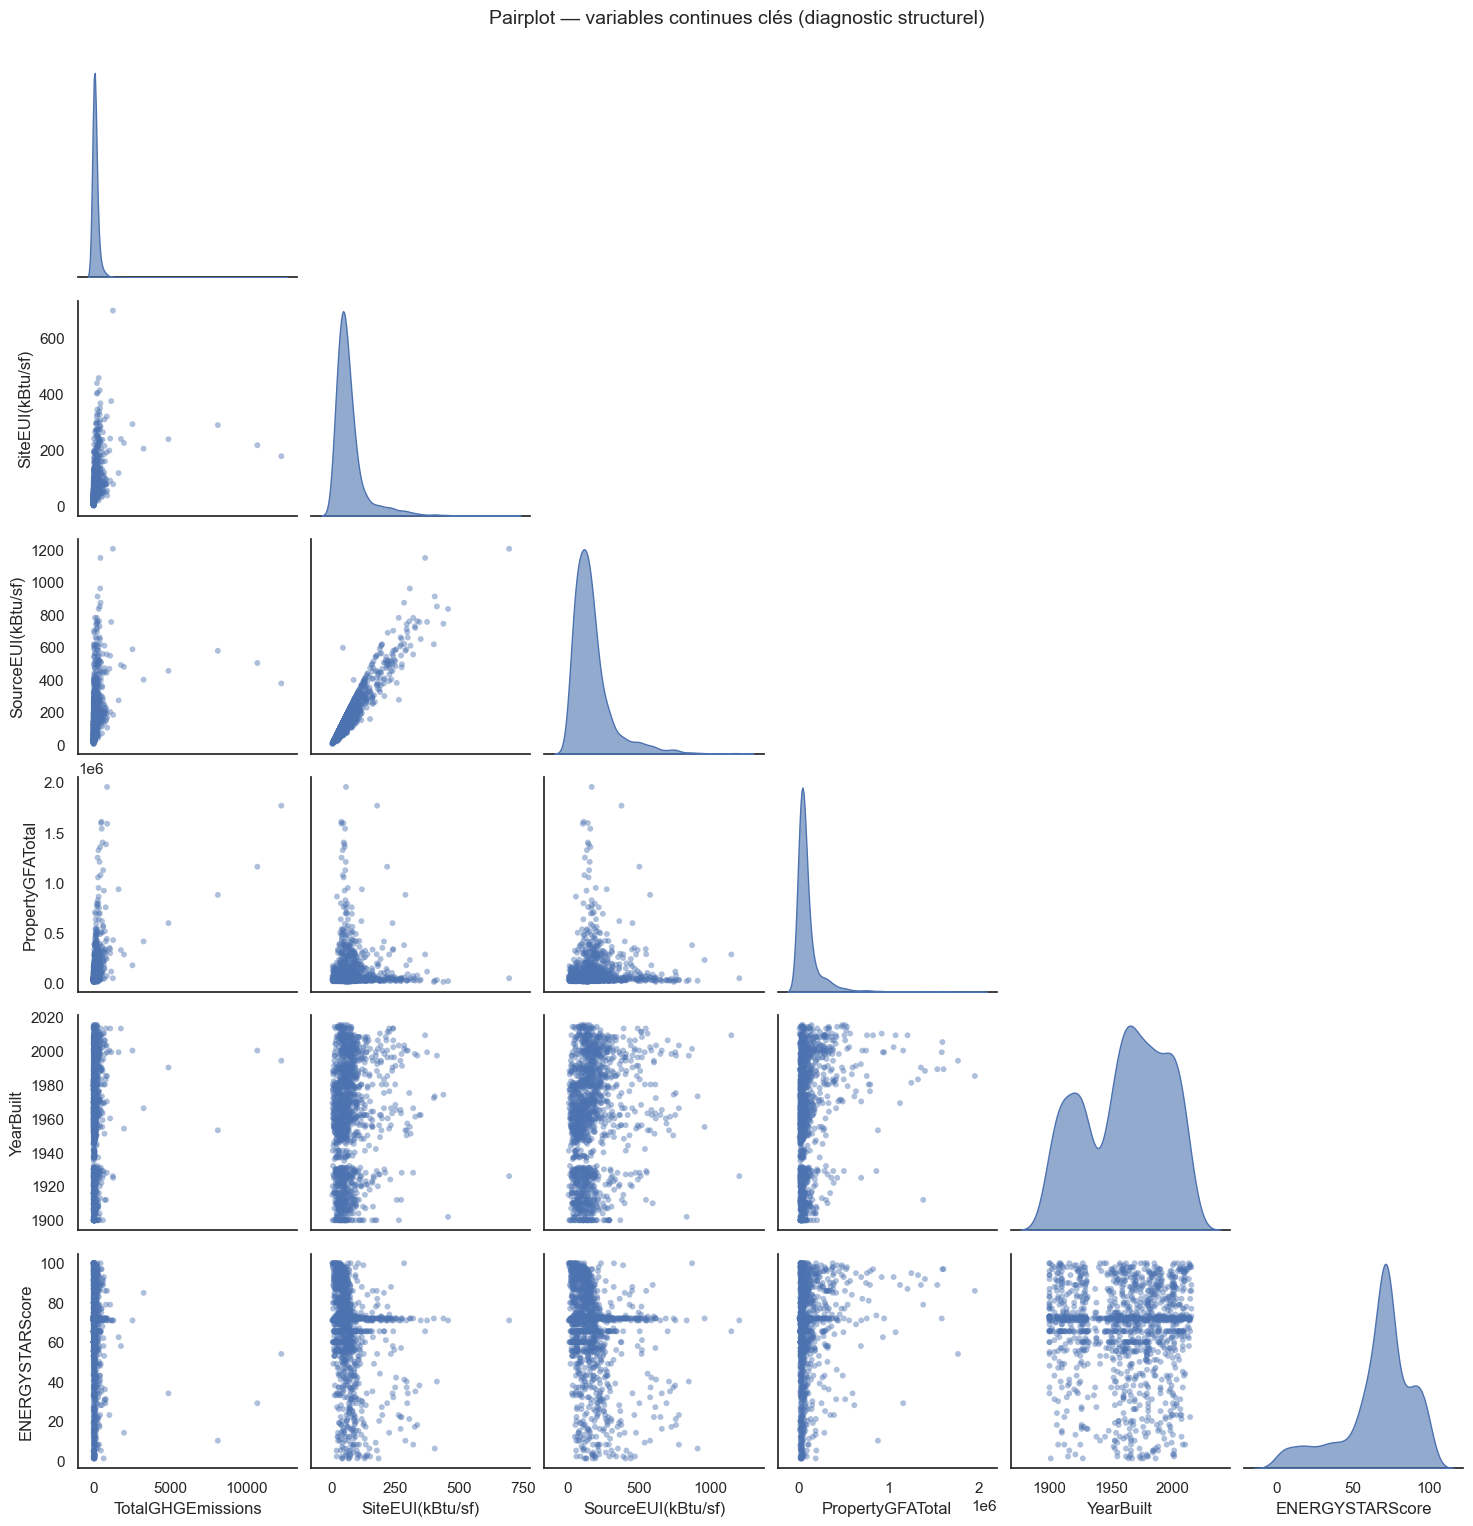

In [3]:
# Sélection stratégique des variables et justification
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cols = [
    "TotalGHGEmissions",
    "SiteEUI(kBtu/sf)",
    "SourceEUI(kBtu/sf)",
    "PropertyGFATotal",
    "YearBuilt",
    "ENERGYSTARScore",
]

df_pair = df[cols].copy()

sns.set_theme(style="white", context="notebook")
g = sns.pairplot(
    df_pair,
    diag_kind="kde",
    corner=True,
    plot_kws={"alpha": 0.45, "s": 18, "edgecolor": "none"},
    diag_kws={"fill": True, "alpha": 0.6},
)
g.fig.suptitle(
    "Pairplot — variables continues clés (diagnostic structurel)",
    y=1.02,
    fontsize=14
)
plt.show()

À la lecture du pairplot, le premier fait marquant est la structure des distributions sur la diagonale : la variable cible **TotalGHGEmissions** est extrêmement asymétrique, avec une masse très dense de bâtiments proches de zéro et une queue longue portée par quelques observations très élevées. Cette géométrie indique que les émissions totales sont gouvernées par une logique de “super-émetteurs” et que la variance augmente fortement avec le niveau d’émission. En pratique, cela signifie que travailler en échelle brute exposera le modèle à une domination des extrêmes (et à une erreur absolue pilotée par quelques points), **ce qui rend la transformation logarithmique de la cible non pas un choix esthétique mais une nécessité pour stabiliser l’apprentissage et rendre l’erreur relative plus pertinente.**

Quand on observe ensuite les croisements entre **SiteEUI** et **TotalGHGEmissions**, on ne voit pas de relation linéaire simple où l’augmentation de l’intensité énergétique entraînerait mécaniquement une hausse des émissions. Au contraire, une grande partie des points reste collée à de faibles niveaux d’émissions alors que l’EUI varie, ce qui traduit visuellement une décorrélation globale entre consommation énergétique “au compteur” et carbone. Ce résultat est cohérent avec le contexte de Seattle : une fraction des bâtiments peut consommer beaucoup d’électricité sans que cela se traduise en émissions élevées, et la présence de quelques bâtiments très émetteurs ne s’aligne pas sur une pente unique de type “plus d’EUI = plus de CO2”. Dit autrement, ce pairplot confirme que l’EUI, pris isolément, est un prédicteur structurellement insuffisant pour expliquer le carbone total dans ce territoire, parce qu’il mélange des usages et des vecteurs énergétiques qui n’ont pas la même intensité carbone.

Le lien entre **SiteEUI** et **SourceEUI** ressort en revanche de façon très nette : le nuage est quasiment une relation monotone serrée, proche d’une droite, ce qui est un diagnostic direct de multicolinéarité. Les deux variables racontent essentiellement la même histoire énergétique et les utiliser simultanément dans un modèle linéaire reviendrait à injecter une redondance qui déstabilise l’estimation des coefficients et rend l’interprétation fragile. La lecture “physique” la plus utile ici est que l’information additionnelle n’est pas dans chacune des deux mesures, mais dans leur écart relatif : ce n’est pas la présence de SiteEUI et SourceEUI ensemble qui est informative, c’est plutôt le ratio ou la différence entre les deux, qui peut refléter la part des pertes amont et, indirectement, la structure du mix.

La variable **PropertyGFATotal** met en évidence un autre mécanisme majeur : l’échelle. Sa distribution est elle aussi très asymétrique, avec beaucoup de bâtiments de petite ou moyenne taille et quelques surfaces extrêmement grandes. Dans les panneaux où la surface croise l’EUI, on distingue un comportement classique : les EUI très élevés apparaissent davantage sur des bâtiments de taille modeste ou à usage spécifique, tandis que les très grandes surfaces sont rarement associées aux valeurs d’EUI les plus extrêmes. Mais dès que l’on revient à **TotalGHGEmissions**, le simple fait d’être grand augmente mécaniquement la probabilité d’avoir des émissions totales élevées, ce qui brouille les relations “pures” entre intensité et émissions. Ce point est essentiel pour l’interprétation : la cible étant une quantité absolue, elle agrège à la fois l’intensité énergétique, la taille du bâtiment et le vecteur énergétique, et le pairplot suggère que ces dimensions se superposent au point de masquer une relation bivariée simple. C’est précisément la raison pour laquelle une analyse en intensité (émissions par surface) ou une segmentation par vecteur (gaz/vapeur vs électrique) est nécessaire pour faire apparaître des structures plus propres.

Concernant **YearBuilt**, le pairplot ne montre pas de décroissance monotone évidente des émissions ou des EUI avec l’année de construction. La dispersion reste forte sur toute la plage temporelle, avec des concentrations par périodes plutôt qu’une pente continue. Cela signifie que l’âge agit davantage comme un marqueur d’“époques” technologiques et réglementaires que comme une variable continue linéaire : les bâtiments anciens peuvent être soit très performants (inertie, rénovations, typologies robustes), soit très mauvais (enveloppes et systèmes dépassés), et les bâtiments récents ne sont pas uniformément sobres car l’usage et les systèmes dominent parfois l’effet enveloppe. Ce comportement est compatible avec l’hypothèse d’effets de seuil liés aux codes, et il justifie une lecture par paliers (binning en périodes réglementaires) plutôt qu’une régression directe sur YearBuilt.

Enfin, **ENERGYSTARScore** n’apparaît pas comme un axe explicatif fort dans ce pairplot. Les nuages sont très dispersés, et l’on observe des bandes horizontales qui suggèrent un score discret ou arrondi, donc moins riche comme mesure continue. Surtout, on ne voit pas de relation stable qui ferait du score une proxy directe du carbone total. Cette observation est cohérente avec un environnement où la qualité “benchmark” énergétique ne se convertit pas mécaniquement en émissions si le carbone dépend d’abord du vecteur (gaz/vapeur versus électricité). Autrement dit, le score peut être utile, mais davantage comme variable secondaire ou contextuelle, et non comme un déterminant principal des émissions totales.

Au total, ce pairplot valide un diagnostic structurel : les émissions totales sont portées par une combinaison d’asymétrie extrême, d’effet d’échelle et de mix énergétique, tandis que l’EUI seul ne fournit pas une relation bivariée stable avec le carbone dans le cas de Seattle. En parallèle, il confirme une redondance forte entre SiteEUI et SourceEUI, qui doit être traitée explicitement pour éviter une multicolinéarité inutile. Si l’objectif est de faire émerger la “fourche” électrique versus fossile que tu anticipes théoriquement, le pairplot montre surtout que cette structure est difficile à lire tant qu’on reste sur des émissions absolues non transformées et non segmentées : il faut soit normaliser (intensités), soit conditionner (par usage, par vapeur/gaz), soit créer des variables de signature énergétique qui isolent la part fossile.

---


# Section 2 : Hypothèses d'interactions et tests

L’objectif de cette section est de tester de manière systématique des interactions “métier”, c’est-à-dire des combinaisons de variables qui ont un sens physique ou opérationnel dans un bâtiment. Une interaction est considérée comme prometteuse si une variable construite à partir de cette interaction présente une association plus forte avec les émissions que chacune des variables prises séparément. La logique est que, dans un système urbain complexe, certaines causes n’agissent pas additivement mais multiplicativement : l’effet d’une variable dépend du niveau d’une autre (taille, âge, système énergétique, forme, etc.). Dans un premier temps, on utilise des tests simples basés sur corrélation et visualisation (scatter plots), non pas comme preuve causale, mais comme filtre pour identifier les interactions qui méritent d’être intégrées ensuite dans un modèle non linéaire ou un modèle avec termes d’interaction explicites.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

def corr_pair(x, y):
    """Retourne Pearson + Spearman (en ignorant NaN)."""
    s = pd.concat([x, y], axis=1).dropna()
    if len(s) < 3:
        return {"Pearson": np.nan, "Spearman": np.nan, "n": len(s)}
    return {
        "Pearson": pearsonr(s.iloc[:,0], s.iloc[:,1])[0],
        "Spearman": spearmanr(s.iloc[:,0], s.iloc[:,1])[0],
        "n": len(s)
    }

def scatter_xy(x, y, title, xlabel, ylabel, logx=False, logy=False):
    s = pd.concat([x, y], axis=1).dropna()
    plt.figure()
    plt.scatter(s.iloc[:,0], s.iloc[:,1], alpha=0.35, s=12)
    if logx: plt.xscale("log")
    if logy: plt.yscale("log")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

## 2.1 PropertyGFA × SiteEUI : amplification “taille × intensité”

Cette hypothèse est justifiée par un mécanisme physique immédiat : SiteEUI mesure une intensité énergétique (énergie par surface), alors que PropertyGFA mesure la surface totale. Leur produit est donc une approximation directe d’une énergie totale consommée sur site. En termes d’émissions absolues, ce qui compte n’est pas seulement qu’un bâtiment soit grand ou qu’il soit intensif, mais la combinaison des deux : une intensité élevée appliquée à une très grande surface produit une consommation totale importante, donc un potentiel d’émissions important, même dans un contexte où l’électricité peut être faiblement carbonée. La création de Interaction_Size_Intensity = PropertyGFA * SiteEUI est donc justifiée comme un proxy de “volume énergétique” et permet de tester si les émissions suivent davantage la logique “quantité totale d’énergie” que la logique “intensité seule”.

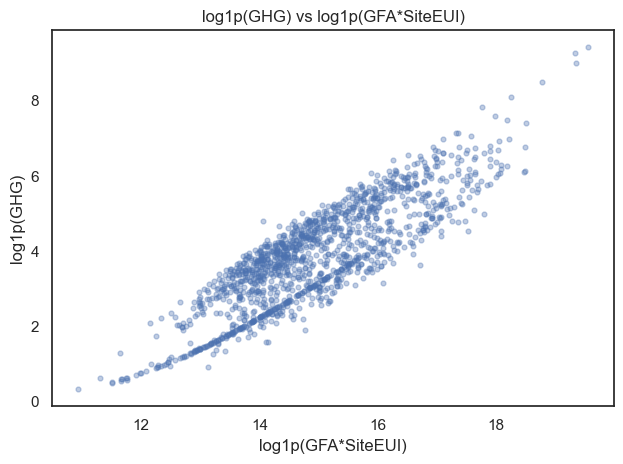

          X                 Y   Pearson  Spearman     n
0       GHG               GFA  0.445023  0.547310  1395
1       GHG           SiteEUI  0.297356  0.659003  1395
2       GHG       GFA*SiteEUI  0.854666  0.825127  1395
3  log(GHG)          log(GFA)  0.589477  0.547310  1395
4  log(GHG)    log1p(SiteEUI)  0.697827  0.659003  1395
5  log(GHG)  log(GFA*SiteEUI)  0.852160  0.825127  1395
Corrélation résiduelle (Pearson): 0.7827027628698897
Corrélation résiduelle (Spearman): 0.7056904557399397


In [13]:
# ---- colonnes
GHG = "TotalGHGEmissions"
GFA = "PropertyGFATotal"          # ou "PropertyGFABuilding(s)"
EUI = "SiteEUI(kBtu/sf)"          # ou "SiteEUI"

df1 = df.copy()
df1 = df1.dropna(subset=[GHG, GFA, EUI])
df1 = df1[(df1[GHG] >= 0) & (df1[GFA] > 0) & (df1[EUI] > 0)]

df1["Interaction_Size_Intensity"] = df1[GFA] * df1[EUI]

# Scatter (souvent plus lisible en log)
scatter_xy(
    x=np.log1p(df1["Interaction_Size_Intensity"]),
    y=np.log1p(df1[GHG]),
    title="log1p(GHG) vs log1p(GFA*SiteEUI)",
    xlabel="log1p(GFA*SiteEUI)",
    ylabel="log1p(GHG)"
)

# Corrélations comparées
res = []
res.append({"X":"GHG", "Y":"GFA", **corr_pair(df1[GHG], df1[GFA])})
res.append({"X":"GHG", "Y":"SiteEUI", **corr_pair(df1[GHG], df1[EUI])})
res.append({"X":"GHG", "Y":"GFA*SiteEUI", **corr_pair(df1[GHG], df1["Interaction_Size_Intensity"])})
res.append({"X":"log(GHG)", "Y":"log(GFA)", **corr_pair(np.log1p(df1[GHG]), np.log(df1[GFA]))})
res.append({"X":"log(GHG)", "Y":"log1p(SiteEUI)", **corr_pair(np.log1p(df1[GHG]), np.log1p(df1[EUI]))})
res.append({"X":"log(GHG)", "Y":"log(GFA*SiteEUI)", **corr_pair(np.log1p(df1[GHG]), np.log(df1["Interaction_Size_Intensity"]))})
corr_table = pd.DataFrame(res)
print(corr_table)

# Corrélation résiduelle (au-delà de la taille)
df1["log_GHG"] = np.log1p(df1[GHG])
df1["log_GFA"] = np.log(df1[GFA])
df1["log_Interact"] = np.log(df1["Interaction_Size_Intensity"])

X = sm.add_constant(df1["log_GFA"])
m_ghg = sm.OLS(df1["log_GHG"], X).fit()
m_int = sm.OLS(df1["log_Interact"], X).fit()

df1["GHG_resid"] = m_ghg.resid
df1["Interact_resid"] = m_int.resid

print("Corrélation résiduelle (Pearson):", corr_pair(df1["GHG_resid"], df1["Interact_resid"])["Pearson"])
print("Corrélation résiduelle (Spearman):", corr_pair(df1["GHG_resid"], df1["Interact_resid"])["Spearman"])


On obtiens `corr(GHG, GFA*SiteEUI)` ≈ **0.855 (Pearson)** et **0.825 (Spearman)**, et en log c’est encore **0.852** / **0.825**. Le scatter log-log montre une relation très structurée, pas juste un nuage flou. Ce point est important : en log, on réduis l’emprise des extrêmes, et pourtant le signal reste massif. Le test “résiduel” calculé est le clou : après avoir retiré l’effet de la taille (via log(GFA)), il reste encore **0.78 (Pearson)** et **0.71 (Spearman)** entre les résidus, donc ce n’est pas uniquement “GFA déguisé” ; il y a bien un effet d’intensité qui continue à expliquer des variations d’émissions à taille comparable.

## 2.2 YearBuilt × ENERGYSTARScore : effet différencié de la performance selon l’âge

Cette hypothèse repose sur une intuition opérationnelle : dans un bâtiment ancien, il existe souvent une marge de progrès plus grande (enveloppe, systèmes HVAC, régulation, éclairage), donc un indicateur de performance ou de bonne exploitation peut avoir un effet plus “révélateur” que dans un bâtiment déjà récent et conforme à des codes plus stricts. Autrement dit, un bon score ENERGYSTAR dans un bâtiment vieux peut signaler une rénovation, une exploitation exemplaire ou un système modernisé ; alors que dans un bâtiment récent, le score peut être plus “facile” à atteindre et moins discriminant. Cette interaction est aussi justifiable parce que les scores type ENERGYSTAR sont des agrégats qui n’épousent pas toujours parfaitement les émissions réelles, surtout dans un réseau électrique décarboné : l’âge peut moduler la relation entre score et émissions via des choix de chauffage (gaz/vapeur) et de systèmes.

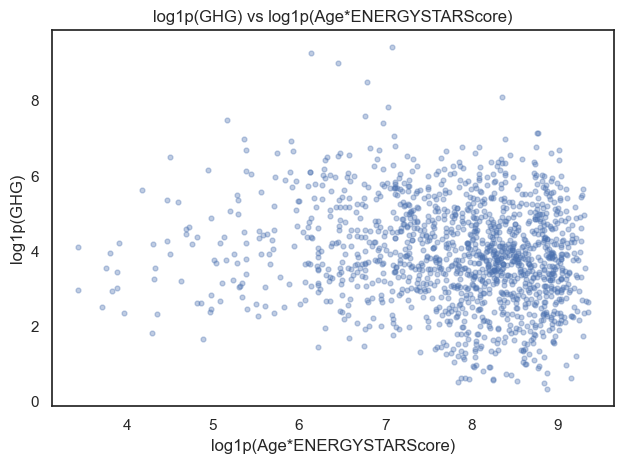

          X                      Y   Pearson  Spearman     n
0       GHG                    Age -0.083933 -0.163592  1395
1       GHG        ENERGYSTARScore -0.075789 -0.028642  1395
2       GHG         Age*ENERGYSTAR -0.094789 -0.159077  1395
3  log(GHG)             log1p(Age) -0.178256 -0.163592  1395
4  log(GHG)      log1p(ENERGYSTAR) -0.023299 -0.028642  1395
5  log(GHG)  log1p(Age*ENERGYSTAR) -0.152727 -0.159077  1395


In [14]:
# ---- colonnes
GHG = "TotalGHGEmissions"
YEAR = "YearBuilt"
ES = "ENERGYSTARScore"
YEAR_REF = 2016

df2 = df.copy()
df2 = df2.dropna(subset=[GHG, YEAR, ES])
df2 = df2[(df2[GHG] >= 0) & (df2[YEAR] > 0) & (df2[ES] > 0)]

df2["Age"] = YEAR_REF - df2[YEAR]
df2 = df2[df2["Age"] >= 0]

df2["Interaction_Age_ENERGY"] = df2["Age"] * df2[ES]

scatter_xy(
    x=np.log1p(df2["Interaction_Age_ENERGY"]),
    y=np.log1p(df2[GHG]),
    title="log1p(GHG) vs log1p(Age*ENERGYSTARScore)",
    xlabel="log1p(Age*ENERGYSTARScore)",
    ylabel="log1p(GHG)"
)

res = []
res.append({"X":"GHG", "Y":"Age", **corr_pair(df2[GHG], df2["Age"])})
res.append({"X":"GHG", "Y":"ENERGYSTARScore", **corr_pair(df2[GHG], df2[ES])})
res.append({"X":"GHG", "Y":"Age*ENERGYSTAR", **corr_pair(df2[GHG], df2["Interaction_Age_ENERGY"])})
res.append({"X":"log(GHG)", "Y":"log1p(Age)", **corr_pair(np.log1p(df2[GHG]), np.log1p(df2["Age"]))})
res.append({"X":"log(GHG)", "Y":"log1p(ENERGYSTAR)", **corr_pair(np.log1p(df2[GHG]), np.log1p(df2[ES]))})
res.append({"X":"log(GHG)", "Y":"log1p(Age*ENERGYSTAR)", **corr_pair(np.log1p(df2[GHG]), np.log1p(df2["Interaction_Age_ENERGY"]))})
print(pd.DataFrame(res))


Le tableau montre `corr(GHG, GFA)` ≈ **0.445 / 0.547**, alors que `corr(GHG, Age*GFA)` est plus faible à **0.317 / 0.362**. Même en log, `log(GHG)` vs `log(GFA)` est à **0.589**, alors que `log(GHG)` vs `log1p(Age*GFA)` est à **0.382**. Donc l’interaction “obsolescence × complexité des gros systèmes” n’émerge pas sous forme d’un signal simple corrélatif avec les émissions totales ; soit l’effet n’existe pas globalement, soit il est masqué par des facteurs dominants (usage, vapeur/gaz, rénovations), soit il est non monotone (très plausible). Le scatter que tu montres a une tendance globale positive, mais elle ressemble surtout à un effet “les grands bâtiments émettent plus” et non à une amplification nette par l’âge.

## 2.3 Electricity × NaturalGas (ou ratio gaz/électricité) : signature du mix énergétique

Cette hypothèse est fortement justifiée par le contexte Seattle : le facteur d’émission de l’électricité est faible, alors que le gaz et la vapeur restent carbonés. Deux bâtiments avec une consommation totale similaire peuvent donc avoir des émissions très différentes selon la part fossile. Une interaction entre consommations électrique et gaz vise à capturer des profils énergétiques distincts : “tout électrique”, “tout gaz”, ou “mix”. Le produit Electricity * NaturalGas peut servir de détecteur de bâtiments à double dépendance énergétique (process + chauffage fossile), souvent associés à des émissions élevées. Le ratio Gas_Electricity_Ratio = NaturalGas / (Electricity + 1) est encore plus interprétable : il agit comme un indicateur direct de “carbonation” du mix.

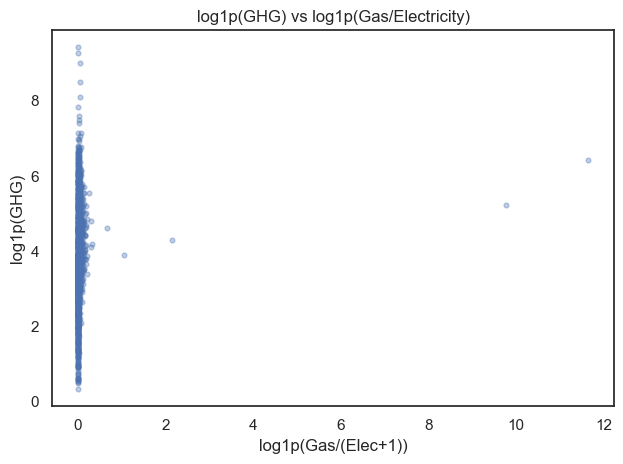

          X                Y   Pearson  Spearman     n
0       GHG      Electricity  0.743491  0.622340  1395
1       GHG       NaturalGas  0.609614  0.726352  1395
2       GHG         Elec*Gas  0.584919  0.747585  1395
3       GHG         Gas/Elec  0.023500  0.410734  1395
4  log(GHG)  log1p(Gas/Elec)  0.075704  0.410734  1395


In [15]:
# ---- colonnes 
GHG = "TotalGHGEmissions"
ELEC = "Electricity(kWh)"         # ou une version kBtu déjà convertie
GAS  = "NaturalGas(therms)"       # ou kBtu

df3 = df.copy()
df3 = df3.dropna(subset=[GHG, ELEC, GAS])
df3 = df3[(df3[GHG] >= 0) & (df3[ELEC] >= 0) & (df3[GAS] >= 0)]

# Produit (attention: dépend des unités)
df3["Energy_Mix_Product"] = df3[ELEC] * df3[GAS]

# Ratio (plus interprétable)
df3["Gas_Electricity_Ratio"] = df3[GAS] / (df3[ELEC] + 1)

scatter_xy(
    x=np.log1p(df3["Gas_Electricity_Ratio"]),
    y=np.log1p(df3[GHG]),
    title="log1p(GHG) vs log1p(Gas/Electricity)",
    xlabel="log1p(Gas/(Elec+1))",
    ylabel="log1p(GHG)"
)

res = []
res.append({"X":"GHG", "Y":"Electricity", **corr_pair(df3[GHG], df3[ELEC])})
res.append({"X":"GHG", "Y":"NaturalGas", **corr_pair(df3[GHG], df3[GAS])})
res.append({"X":"GHG", "Y":"Elec*Gas", **corr_pair(df3[GHG], df3["Energy_Mix_Product"])})
res.append({"X":"GHG", "Y":"Gas/Elec", **corr_pair(df3[GHG], df3["Gas_Electricity_Ratio"])})
res.append({"X":"log(GHG)", "Y":"log1p(Gas/Elec)", **corr_pair(np.log1p(df3[GHG]), np.log1p(df3["Gas_Electricity_Ratio"]))})
print(pd.DataFrame(res))



C’est un résultat hyper instructif : tu trouves une corrélation modérée entre **GHG** et `Footprint/Floor` (≈ **0.259 / 0.283**), mais dès que tu regardes **GHGIntensity**, la corrélation tombe à ~0 (Pearson **0.005**, Spearman **-0.048**, et pareil en log). Ça veut dire que la variable “empreinte au sol par étage” n’explique pas l’intensité carbone dans le dataset, et que la corrélation avec GHG total vient surtout du fait que `Footprint/Floor` reste une quantité liée à la taille/typologie et donc récupère un bout de l’effet échelle.

## 2.4 PropertyGFA / NumberofFloors : morphologie “empreinte au sol” et pertes thermiques

Cette hypothèse est justifiée par la physique de l’enveloppe. À surface totale égale, la forme du bâtiment influence les pertes et gains thermiques (ratio surface d’enveloppe / volume, exposition du toit, façades). Footprint_per_Floor = PropertyGFA / NumberofFloors sert de proxy de l’emprise au sol : une valeur élevée correspond à un bâtiment étalé (“pancake”), tandis qu’une valeur faible correspond à un bâtiment plus vertical (“slender”). Ces typologies peuvent avoir des profils énergétiques différents : les bâtiments étalés ont souvent plus de surface de toit par m² utile, tandis que les tours ont davantage de façade exposée au vent, et des besoins additionnels (ascenseurs, pompes). L’interaction n’est pas juste mathématique : elle cherche à capter une dimension géométrique absente des variables brutes.

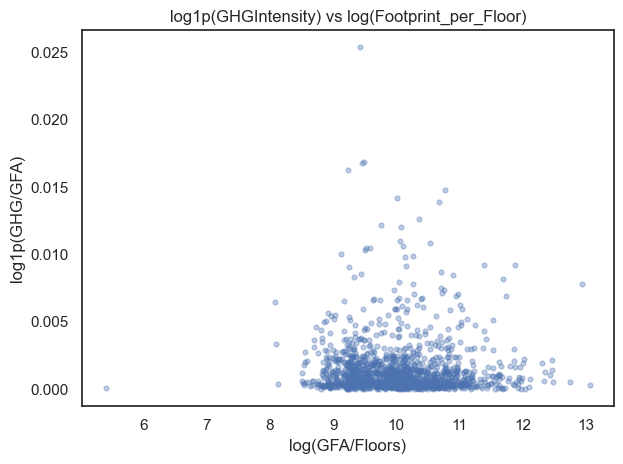

                   X                     Y   Pearson  Spearman     n
0                GHG       Footprint/Floor  0.259226  0.282758  1395
1       GHGIntensity       Footprint/Floor  0.004989 -0.047769  1395
2  log(GHGIntensity)  log(Footprint/Floor) -0.011222 -0.047769  1395


In [16]:
# ---- colonnes
GHG = "TotalGHGEmissions"
GFA = "PropertyGFATotal"
FLOORS = "NumberofFloors"

df4 = df.copy()
df4 = df4.dropna(subset=[GHG, GFA, FLOORS])
df4 = df4[(df4[GHG] >= 0) & (df4[GFA] > 0) & (df4[FLOORS] > 0)]

df4["Footprint_per_Floor"] = df4[GFA] / df4[FLOORS]

# Option utile : intensité carbone (évite que "total GHG" soit dominé par la taille)
df4["GHGIntensity"] = df4[GHG] / df4[GFA]

scatter_xy(
    x=np.log(df4["Footprint_per_Floor"]),
    y=np.log1p(df4["GHGIntensity"]),
    title="log1p(GHGIntensity) vs log(Footprint_per_Floor)",
    xlabel="log(GFA/Floors)",
    ylabel="log1p(GHG/GFA)"
)

res = []
res.append({"X":"GHG", "Y":"Footprint/Floor", **corr_pair(df4[GHG], df4["Footprint_per_Floor"])})
res.append({"X":"GHGIntensity", "Y":"Footprint/Floor", **corr_pair(df4["GHGIntensity"], df4["Footprint_per_Floor"])})
res.append({"X":"log(GHGIntensity)", "Y":"log(Footprint/Floor)", **corr_pair(np.log1p(df4["GHGIntensity"]), np.log(df4["Footprint_per_Floor"]))})
print(pd.DataFrame(res))


On observes `Age` légèrement négatif avec GHG (faible), `ENERGYSTARScore` légèrement négatif aussi (très faible), et leur interaction reste faible et négative (et en log tu es autour de **-0.15** en Pearson/Spearman). Le scatter ne montre pas de structure claire. Interprétation : sur ces données, ENERGYSTAR n’agit pas comme un modulateur “plus utile sur les vieux bâtiments”, soit parce que le score est trop bruité/discret, soit parce qu’à Seattle l’électricité faiblement carbonée casse la correspondance entre performance énergétique “benchmark” et émissions réelles, soit parce que l’effet âge est dominé par rénovations et systèmes (gaz/vapeur) plutôt que par l’année brute.

## 2.5 Age (2016 − YearBuilt) et interactions dérivées : hystérésis réglementaire et obsolescence système

L’âge est une variable dérivée simple mais souvent plus interprétable que l’année brute, parce qu’elle correspond mieux à l’idée de vieillissement des systèmes, de dérive des réglages, et de probabilité d’être construit sous un code énergétique ancien. L’hypothèse métier est que l’âge agit comme un facteur de risque énergétique et carbone, mais pas forcément de façon linéaire : certains bâtiments anciens ont été rénovés, d’autres non. Malgré cela, Age sert de “prior” utile.

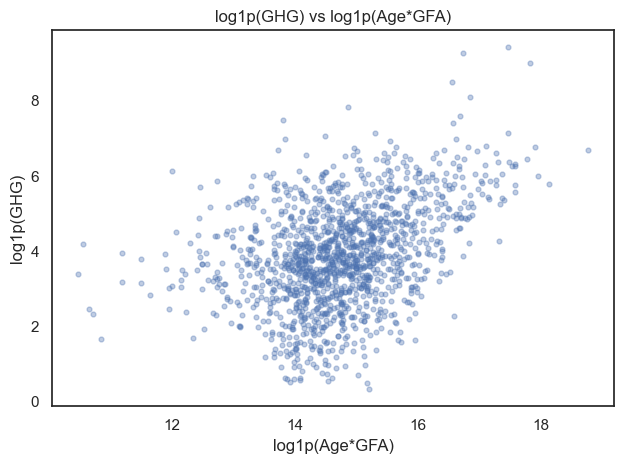

          X               Y   Pearson  Spearman     n
0       GHG             Age -0.083933 -0.163592  1395
1       GHG             GFA  0.445023  0.547310  1395
2       GHG         Age*GFA  0.316986  0.361656  1395
3  log(GHG)      log1p(Age) -0.178256 -0.163592  1395
4  log(GHG)        log(GFA)  0.589477  0.547310  1395
5  log(GHG)  log1p(Age*GFA)  0.382302  0.361656  1395


In [17]:
# ---- colonnes
GHG = "TotalGHGEmissions"
GFA = "PropertyGFATotal"
YEAR = "YearBuilt"
YEAR_REF = 2016

df5 = df.copy()
df5 = df5.dropna(subset=[GHG, GFA, YEAR])
df5 = df5[(df5[GHG] >= 0) & (df5[GFA] > 0) & (df5[YEAR] > 0)]

df5["Age"] = YEAR_REF - df5[YEAR]
df5 = df5[df5["Age"] >= 0]

df5["Age_x_GFA"] = df5["Age"] * df5[GFA]

scatter_xy(
    x=np.log1p(df5["Age_x_GFA"]),
    y=np.log1p(df5[GHG]),
    title="log1p(GHG) vs log1p(Age*GFA)",
    xlabel="log1p(Age*GFA)",
    ylabel="log1p(GHG)"
)

res = []
res.append({"X":"GHG", "Y":"Age", **corr_pair(df5[GHG], df5["Age"])})
res.append({"X":"GHG", "Y":"GFA", **corr_pair(df5[GHG], df5[GFA])})
res.append({"X":"GHG", "Y":"Age*GFA", **corr_pair(df5[GHG], df5["Age_x_GFA"])})
res.append({"X":"log(GHG)", "Y":"log1p(Age)", **corr_pair(np.log1p(df5[GHG]), np.log1p(df5["Age"]))})
res.append({"X":"log(GHG)", "Y":"log(GFA)", **corr_pair(np.log1p(df5[GHG]), np.log(df5[GFA]))})
res.append({"X":"log(GHG)", "Y":"log1p(Age*GFA)", **corr_pair(np.log1p(df5[GHG]), np.log1p(df5["Age_x_GFA"]))})
print(pd.DataFrame(res))


Le ratio `Gas/(Elec+1)` a un **Pearson quasi nul** (~0.02–0.08) mais un **Spearman ≈ 0.41**, et le nuage montre une énorme concentration près de zéro (bâtiments très peu gaz ou beaucoup électricité) et quelques points extrêmes très à droite. Ça explique l’écart : Spearman capte un ordre monotone (quand le ratio augmente, GHG tend à augmenter), mais Pearson ne voit rien parce que la relation n’est pas linéaire et que la distribution est écrasée par la masse à zéro + quelques outliers.

---

Dans cet écran de tests, une seule interaction ressort comme franchement prometteuse : `GFA × SiteEUI`, qui présente une corrélation très supérieure aux variables individuelles et conserve un signal fort même après neutralisation de l’effet taille. Les interactions basées sur l’âge (`Age × GFA`, `Age × ENERGYSTARScore`) ne montrent pas d’amélioration et semblent insuffisantes pour capturer un mécanisme stable au niveau global. La variable morphologique `GFA/Floors` ne présente pas de relation avec l’intensité carbone, ce qui suggère que la forme n’est pas captée par ce proxy dans ces données ou que l’effet est dominé par le mix énergétique et l’usage. Enfin, le ratio `Gas/Electricity` présente une relation monotone mais très non linéaire et fortement concentrée près de zéro, indiquant que la question du mix est réelle mais nécessite une feature plus robuste (part fossile, indicateurs gaz/vapeur).


# Section 3 : Analyse conditionnelle — Effets contextuels

Dans cette section, l’objectif est de vérifier si les relations observées globalement masquent des comportements opposés au sein de sous-groupes, ce qui correspond au risque classique du paradoxe de Simpson. Plutôt que de supposer qu’une relation bivariée est stable sur l’ensemble du parc, on la visualise et on la quantifie dans plusieurs contextes (usage, quartier, tranche d’âge), afin d’identifier des effets conditionnels. Lorsque les pentes ou les structures changent fortement selon le contexte, cela indique qu’un modèle global linéaire sera insuffisant et qu’il faudra soit intégrer des interactions explicites, soit privilégier des modèles non linéaires capables de capturer ces régimes.

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Style minimal
sns.set_context("notebook")

# Colonnes
COL_GHG = "TotalGHGEmissions"
COL_GFA = "PropertyGFATotal"
COL_EUI = "SiteEUI(kBtu/sf)"
COL_YEAR = "YearBuilt"
COL_TYPE = "PrimaryPropertyType"
COL_NEI = "Neighborhood"
COL_ES = "ENERGYSTARScore"

# Nettoyage minimal + logs utiles
dfc = df.copy()
dfc = dfc.dropna(subset=[COL_GHG])
dfc = dfc[dfc[COL_GHG] >= 0].copy()
dfc["log_GHG"] = np.log1p(dfc[COL_GHG])

def top_categories(frame, col, n=8, min_count=30):
    vc = frame[col].value_counts()
    keep = vc[vc >= min_count].head(n).index
    return list(keep)

def facet_scatter_reg(frame, x, y, facet_col, order=None, col_wrap=4, height=3.2, sharex=True, sharey=True, title=None):
    d = frame.dropna(subset=[x, y, facet_col]).copy()
    if order is not None:
        d = d[d[facet_col].isin(order)]
        d[facet_col] = pd.Categorical(d[facet_col], categories=order, ordered=True)

    g = sns.FacetGrid(d, col=facet_col, col_wrap=col_wrap, height=height, sharex=sharex, sharey=sharey)
    g.map_dataframe(sns.scatterplot, x=x, y=y, alpha=0.25, s=12)
    # Ligne de tendance (simple) par facet
    g.map_dataframe(sns.regplot, x=x, y=y, scatter=False, ci=None, line_kws={"linewidth": 2})
    g.set_axis_labels(x, y)
    if title:
        g.fig.suptitle(title, y=1.02)
    plt.show()

def slopes_table(frame, x, y, group_col, groups):
    """
    Calcule une pente OLS y ~ x par groupe (sur les données filtrées).
    C'est un résumé simple pour comparer les facets.
    """
    rows = []
    for g in groups:
        d = frame.dropna(subset=[x, y, group_col])
        d = d[d[group_col] == g]
        if len(d) < 20:
            continue
        X = sm.add_constant(d[x])
        m = sm.OLS(d[y], X).fit()
        rows.append({
            group_col: g,
            "n": len(d),
            "slope": m.params.get(x, np.nan),
            "R2": m.rsquared
        })
    return pd.DataFrame(rows).sort_values("R2", ascending=False)

## 3.1 - GHG vs PropertyGFA segmenté par PrimaryPropertyType

On vérifie si la relation entre la taille (surface) et les émissions totales est stable selon l’usage. Si les pentes diffèrent fortement, cela signifie que l’effet de la surface dépend du type de bâtiment, ce qui correspond à un effet d’interaction Type × Taille.

Types retenus: ['Small- and Mid-Sized Office', 'Other', 'Warehouse', 'Large Office', 'Mixed Use Property', 'Retail Store', 'Hotel', 'Worship Facility']


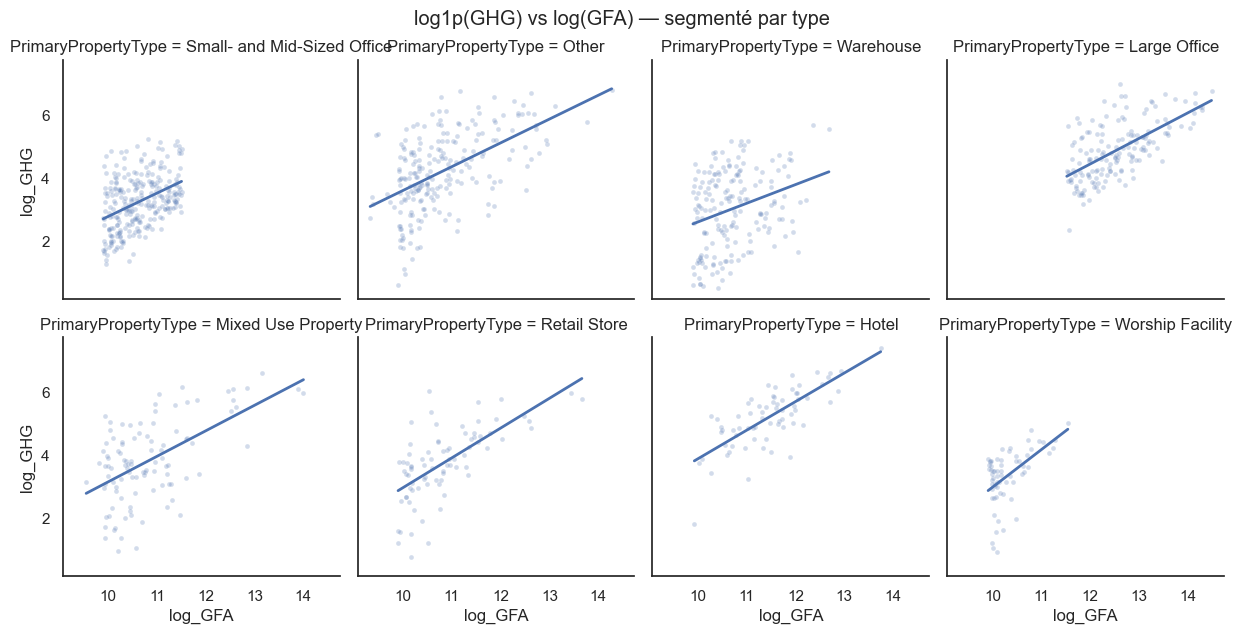

           PrimaryPropertyType    n     slope        R2
6                        Hotel   68  0.912015  0.557355
5                 Retail Store   79  0.949856  0.437208
3                 Large Office  160  0.815551  0.401364
4           Mixed Use Property  102  0.814447  0.315025
1                        Other  220  0.758787  0.288216
7             Worship Facility   64  1.198061  0.276885
0  Small- and Mid-Sized Office  272  0.743947  0.172346
2                    Warehouse  178  0.596412  0.085951


In [19]:
types_top = top_categories(dfc.dropna(subset=[COL_TYPE, COL_GFA]), COL_TYPE, n=8, min_count=30)
print("Types retenus:", types_top)

# log-log pour stabiliser les extrêmes
dA = dfc.dropna(subset=[COL_GFA, COL_TYPE]).copy()
dA = dA[dA[COL_GFA] > 0]
dA["log_GFA"] = np.log(dA[COL_GFA])

facet_scatter_reg(
    dA, x="log_GFA", y="log_GHG", facet_col=COL_TYPE, order=types_top,
    col_wrap=4, height=3.1,
    title="log1p(GHG) vs log(GFA) — segmenté par type"
)

tableA = slopes_table(dA, x="log_GFA", y="log_GHG", group_col=COL_TYPE, groups=types_top)
print(tableA)

Les facettes montrent une relation taille → émissions qui existe partout, mais dont l’intensité et la stabilité varient énormément selon le type. Les hôtels et les retail stores ressortent comme des groupes où la relation est particulièrement structurée, avec des R² élevés (Hotel ≈ 0.56, Retail Store ≈ 0.44) et des pentes fortes (Hotel ≈ 0.91, Retail Store ≈ 0.95). Dans ces segments, augmenter la surface entraîne de manière assez régulière une augmentation des émissions, ce qui suggère que les mécanismes dominants (occupation, systèmes, besoins thermiques) sont relativement homogènes au sein du type.

À l’opposé, les warehouses ont une pente plus faible (≈ 0.60) et surtout un R² très bas (≈ 0.086). Autrement dit, pour les entrepôts, la taille seule explique très peu les émissions : à surface comparable, on peut avoir des niveaux d’émissions très différents. C’est cohérent avec un usage où l’activité (chauffage minimal, éclairage, process éventuel) et le vecteur énergétique pèsent plus que la géométrie brute. Les catégories “Other” et “Small-/Mid-Sized Office” sont intermédiaires : la pente reste positive mais le nuage est plus dispersé (R² plus modestes), ce qui indique que “bureau” n’est pas un comportement énergétique unique et qu’il existe probablement plusieurs régimes internes (gaz vs élec, rénovation, downtown vs hors-centre, etc.).

Ce résultat justifie directement une stratégie de modélisation qui inclut des interactions Type × log(GFA), ou une segmentation par type pour les catégories majeures. La taille n’a clairement pas le même “rendement carbone” selon l’usage.

## 3.2 - GHG vs YearBuilt segmenté par Neighborhood

On teste si l’effet apparent de l’âge varie selon la géographie. Si les quartiers montrent des tendances opposées, cela suggère des différences d’infrastructures (vapeur/gaz), de typologies, ou de politiques locales de rénovation.

Neighborhoods retenus: ['DOWNTOWN', 'GREATER DUWAMISH', 'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'EAST', 'NORTHEAST', 'NORTHWEST', 'BALLARD']


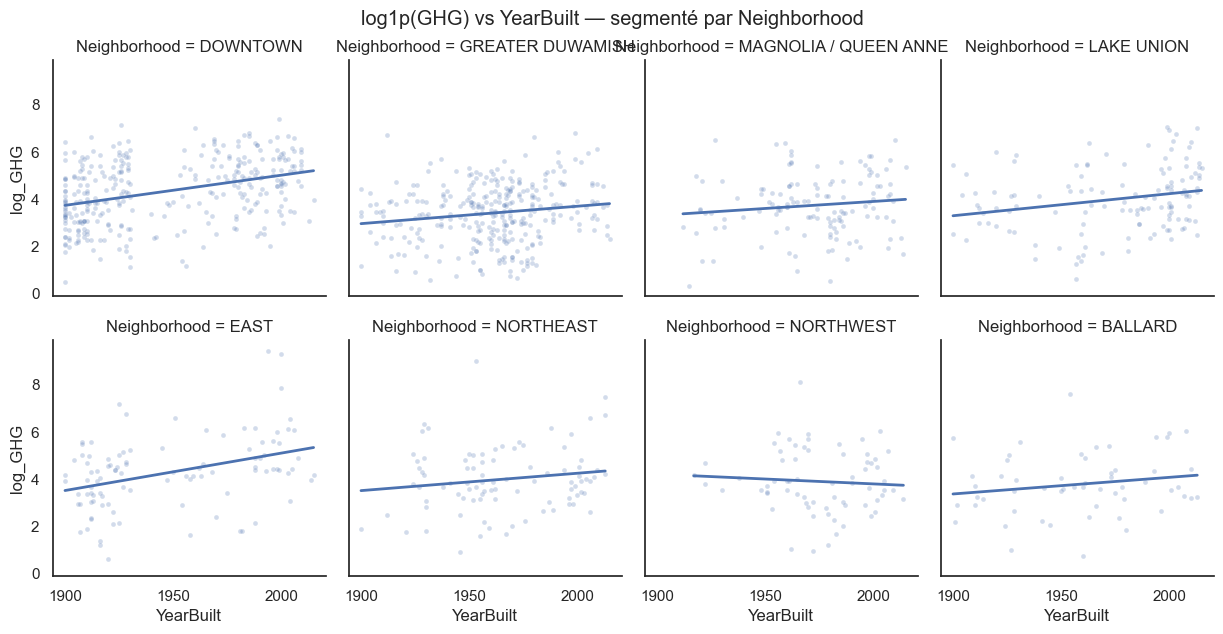

            Neighborhood    n     slope        R2
4                   EAST  101  0.015832  0.139725
0               DOWNTOWN  322  0.012757  0.127571
3             LAKE UNION  126  0.009334  0.053587
7                BALLARD   56  0.007036  0.031083
1       GREATER DUWAMISH  308  0.007369  0.024377
5              NORTHEAST   90  0.007348  0.023356
2  MAGNOLIA / QUEEN ANNE  129  0.005936  0.014502
6              NORTHWEST   68 -0.004128  0.004922


In [20]:
neigh_top = top_categories(dfc.dropna(subset=[COL_NEI, COL_YEAR]), COL_NEI, n=8, min_count=30)
print("Neighborhoods retenus:", neigh_top)

dB = dfc.dropna(subset=[COL_YEAR, COL_NEI]).copy()
dB = dB[(dB[COL_YEAR] >= 1800) & (dB[COL_YEAR] <= 2016)]

# Année brute en x, log_GHG en y
facet_scatter_reg(
    dB, x=COL_YEAR, y="log_GHG", facet_col=COL_NEI, order=neigh_top,
    col_wrap=4, height=3.1, sharex=True, sharey=True,
    title="log1p(GHG) vs YearBuilt — segmenté par Neighborhood"
)

tableB = slopes_table(dB, x=COL_YEAR, y="log_GHG", group_col=COL_NEI, groups=neigh_top)
print(tableB)

Ici, les pentes par quartier sont petites et les R² restent faibles dans toutes les facettes. Même les quartiers les plus “explicatifs” dans ton tableau (EAST R² ≈ 0.14, DOWNTOWN R² ≈ 0.13) restent loin d’un signal robuste. La pente est légèrement positive dans la plupart des quartiers et légèrement négative seulement pour NORTHWEST (pente très faible en valeur absolue), ce qui signifie qu’il n’y a pas de relation stable “plus récent = moins d’émissions” ou “plus ancien = plus d’émissions” qui se reproduit nettement quartier par quartier.

Ce que ça raconte, c’est que YearBuilt, pris seul, n’est pas un bon proxy universel des émissions dans le dataset. Si des différences d’infrastructure existent (vapeur/district, gaz), elles ne se traduisent pas ici par une relation simple entre année de construction et émissions. Cela ne dit pas que le quartier n’a aucun effet sur le carbone ; ça dit que l’effet ne passe pas par une pente YearBuilt → GHG lisible dans cette coupe, et qu’il est probablement dominé par d’autres facteurs (mix énergétique, usage exact, taille, raccordement vapeur) ou par des effets de sélection (certains quartiers concentrent des bâtiments spécifiques).

En pratique, ça soutient l’idée que l’information géographique doit être captée autrement qu’avec “YearBuilt par quartier” : typiquement via un proxy d’infrastructure (Steam district / HasSteam) plutôt que via une simple tendance temporelle.

## 3.3 — GHG vs SiteEUI segmenté par tranche d’âge

On vérifie si la relation intensité énergétique → émissions est stable dans le temps, ou si elle change selon les générations de bâtiments. C’est un test direct de “régimes” (anciens vs récents), compatible avec l’idée que le mix énergétique et les systèmes évoluent par paliers.

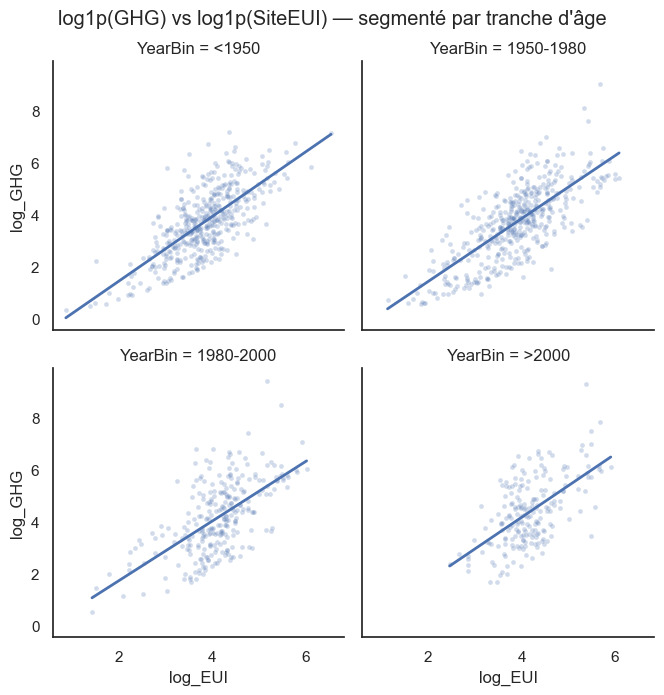

     YearBin    n     slope        R2
1  1950-1980  463  1.208703  0.551514
0      <1950  453  1.242371  0.509131
2  1980-2000  275  1.145683  0.370180
3      >2000  204  1.214551  0.346978


In [21]:
dC = dfc.dropna(subset=[COL_EUI, COL_YEAR]).copy()
dC = dC[(dC[COL_EUI] > 0) & (dC[COL_YEAR] >= 1800) & (dC[COL_YEAR] <= 2016)]

# Bins proposés
bins = [-np.inf, 1949, 1979, 1999, np.inf]
labels = ["<1950", "1950-1980", "1980-2000", ">2000"]
dC["YearBin"] = pd.cut(dC[COL_YEAR], bins=bins, labels=labels)

dC["log_EUI"] = np.log1p(dC[COL_EUI])

facet_scatter_reg(
    dC.dropna(subset=["YearBin"]), x="log_EUI", y="log_GHG", facet_col="YearBin",
    order=labels, col_wrap=2, height=3.4, sharex=True, sharey=True,
    title="log1p(GHG) vs log1p(SiteEUI) — segmenté par tranche d'âge"
)

tableC = slopes_table(dC.dropna(subset=["YearBin"]), x="log_EUI", y="log_GHG", group_col="YearBin", groups=labels)
print(tableC)

Sur les quatre tranches, la relation entre log(EUI) et log(GHG) est clairement positive, ce qui est cohérent : plus l’intensité énergétique monte, plus les émissions montent, même à Seattle, parce que l’EUI agrège aussi des consommations fossiles et que les gros émetteurs sont en général énergivores. Là où ça devient intéressant, c’est la qualité du signal.

Les bins anciens sont ceux où la relation est la plus stable : les R² sont élevés pour <1950 (≈ 0.51) et surtout 1950–1980 (≈ 0.55). À partir de 1980–2000, le R² baisse (≈ 0.37), et il baisse encore pour >2000 (≈ 0.35). Les pentes restent du même ordre (autour de 1.14 à 1.24), donc ce n’est pas un changement radical de pente, c’est surtout une augmentation de la dispersion dans le bâti plus récent.

L’interprétation la plus solide ici est que, dans les bâtiments récents, l’EUI explique moins bien les émissions parce que le “mix” et les choix de systèmes deviennent plus hétérogènes : certains bâtiments récents peuvent avoir une forte intensité électrique mais un carbone relativement faible, tandis que d’autres peuvent rester fossiles (gaz/vapeur) malgré une enveloppe moderne. Autrement dit, la relation EUI → carbone existe, mais elle est de plus en plus conditionnelle au vecteur énergétique. Ce résultat renforce l’idée que, pour la prédiction GHG, il faut intégrer explicitement des features de signature énergétique (gaz/vapeur/élec, part fossile) et ne pas compter sur l’EUI comme prédicteur unique.

## 3.4 — GHG vs ENERGYSTARScore segmenté par BuildingType

On teste si le score ENERGYSTAR est informatif de la performance carbone de manière uniforme, ou seulement pour certains usages. Si la relation change selon le type, cela signale une interaction Type × Score, et un risque de mauvaise généralisation si on utilise le score brut dans un modèle global.


Types retenus: ['Small- and Mid-Sized Office', 'Other', 'Warehouse', 'Large Office', 'Mixed Use Property', 'Retail Store', 'Hotel', 'Worship Facility']


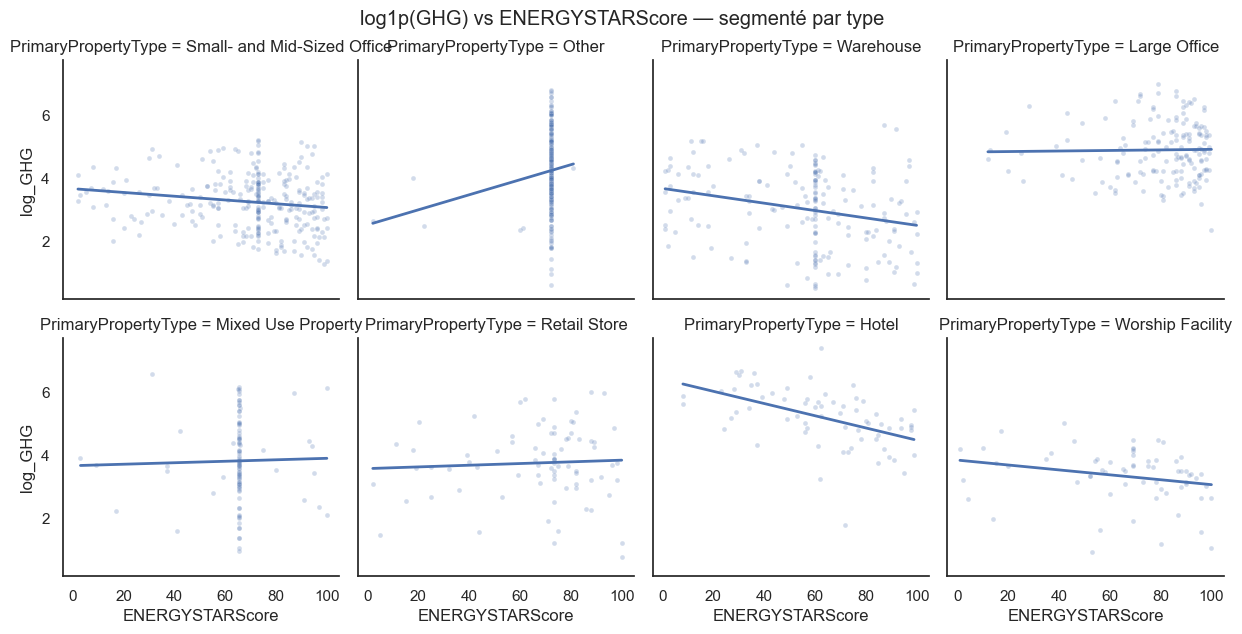

           PrimaryPropertyType    n     slope        R2
6                        Hotel   68 -0.019442  0.244305
2                    Warehouse  178 -0.011751  0.066681
7             Worship Facility   64 -0.007825  0.055607
0  Small- and Mid-Sized Office  272 -0.006009  0.025571
1                        Other  220  0.023938  0.018042
5                 Retail Store   79  0.002681  0.003126
4           Mixed Use Property  102  0.002353  0.000678
3                 Large Office  160  0.000875  0.000327


In [22]:
types_top2 = top_categories(dfc.dropna(subset=[COL_TYPE, COL_ES]), COL_TYPE, n=8, min_count=30)
print("Types retenus:", types_top2)

dD = dfc.dropna(subset=[COL_ES, COL_TYPE]).copy()
dD = dD[(dD[COL_ES] > 0) & (dD[COL_ES] <= 100)]

# Score en x (pas besoin de log), log_GHG en y
facet_scatter_reg(
    dD, x=COL_ES, y="log_GHG", facet_col=COL_TYPE, order=types_top2,
    col_wrap=4, height=3.1, sharex=True, sharey=True,
    title="log1p(GHG) vs ENERGYSTARScore — segmenté par type"
)

tableD = slopes_table(dD, x=COL_ES, y="log_GHG", group_col=COL_TYPE, groups=types_top2)
print(tableD)

Dans la plupart des types, la pente est très proche de zéro et les R² sont extrêmement faibles. Cela signifie que, dans le dataset, l’ENERGYSTARScore n’est pas un prédicteur stable des émissions absolues quand on regarde type par type. Il y a une exception notable : la facette Hotel montre une pente nettement négative (≈ -0.019) avec un R² non négligeable (≈ 0.24), ce qui indique que pour les hôtels, un meilleur score est réellement associé à des émissions plus faibles, de façon suffisamment régulière pour émerger statistiquement.

Pour Warehouse et Worship Facility, la pente est aussi négative mais le R² reste faible, donc ce n’est pas assez structuré pour en faire un signal fort. Le groupe “Other” montre même une pente positive, mais avec un R² quasi nul, ce qui est typique d’un artefact dû à la dispersion et à l’hétérogénéité interne.

La lecture globale est que l’ENERGYSTARScore n’a pas une relation “universelle” avec le carbone à Seattle, ce qui est cohérent avec un territoire où l’électricité est faiblement carbonée et où le score peut être plus aligné sur une performance énergétique relative que sur la réalité des émissions. En modélisation, ce score peut rester utile, mais plutôt comme feature secondaire, et possiblement via une interaction avec le type (puisque Hotel ressort clairement).

---

Cette segmentation montre que plusieurs relations changent de comportement dès qu’on conditionne, ce qui confirme le risque de paradoxe de Simpson et rend fragile toute approche linéaire globale sans interactions. L’effet de la surface sur les émissions dépend nettement du type, ce qui justifie soit des interactions Type × Taille, soit des modèles capables d’apprendre des régimes (arbres, boosting). La relation entre intensité énergétique et émissions existe dans toutes les tranches d’âge, mais elle devient moins “prédictive” dans le bâti récent, ce qui pointe directement vers la nécessité de variables de mix énergétique pour expliquer pourquoi deux bâtiments à EUI comparable ont des émissions différentes. L’âge par quartier ne produit pas un signal exploitable sous forme de tendance simple, ce qui suggère que l’effet géographique, s’il existe, doit être capté via des proxies d’infrastructure (vapeur/district) plutôt que via une pente YearBuilt. Enfin, ENERGYSTARScore est globalement faible comme prédicteur des émissions, avec une exception claire sur les hôtels, ce qui plaide pour un usage conditionnel du score plutôt qu’une interprétation globale.

# Section 4 : Clustering exploratoire

Cette section explore l’existence d’archétypes naturels de bâtiments, c’est-à-dire des groupes présentant des profils énergétiques et structurels similaires. L’objectif n’est pas de prédire directement les émissions, mais d’identifier des régimes de fonctionnement plausibles (petits bâtiments sobres, tours anciennes, bâtiments très intensifs, etc.) afin d’améliorer l’interprétation métier et de guider le feature engineering. La méthode repose sur un clustering K-means appliqué à un ensemble de variables numériques standardisées. Plusieurs valeurs de k sont testées et évaluées via l’inertie (méthode du coude) et le silhouette score. Une fois k choisi, les clusters sont caractérisés par leurs statistiques (émissions moyennes, intensité carbone, variables de profil) et visualisés via une projection PCA en 2D.

In [ ]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Colonnes
COL_GHG  = "TotalGHGEmissions"
COL_GFA  = "PropertyGFATotal"          # ou PropertyGFABuilding(s)
COL_YEAR = "YearBuilt"
COL_EUI  = "SiteEUI(kBtu/sf)"
COL_ES   = "ENERGYSTARScore"
COL_ELEC = "Electricity(kWh)"          
COL_GAS  = "NaturalGas(therms)"        
COL_TYPE = "PrimaryPropertyType"

# Variables utilisées pour le clustering (numériques)
cluster_vars = [COL_GFA, COL_YEAR, COL_EUI, COL_ES, COL_ELEC, COL_GAS]

# Jeu de travail
d = df.copy()

# GHGIntensity pour la caractérisation (pas dans le clustering si on veux éviter target leakage)
# Ici on l'utilise seulement pour profiler les clusters ensuite.
d = d.dropna(subset=[COL_GHG, COL_GFA])
d = d[(d[COL_GHG] >= 0) & (d[COL_GFA] > 0)].copy()
d["GHGIntensity"] = d[COL_GHG] / d[COL_GFA]

# Filtrage minimal sur les variables du clustering
d = d.dropna(subset=[c for c in cluster_vars if c in d.columns])

# Option utile: log-transform sur variables très asymétriques (avant standardisation)
# Attention: on garde YearBuilt brut (pas log), on log1p sur grandeurs positives
d_clust = d.copy()
for c in [COL_GFA, COL_EUI, COL_ELEC, COL_GAS]:
    if c in d_clust.columns:
        d_clust[c] = np.log1p(d_clust[c].clip(lower=0))

# Matrice X
X = d_clust[cluster_vars].copy()

# Imputation + standardisation
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_imp = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imp)

print("Shape clustering:", X_scaled.shape)


Shape clustering: (1395, 6)


   k      inertia  silhouette
0  3  5373.027815    0.196547
1  4  4712.132037    0.213298
2  5  4279.555262    0.195491
3  6  3815.705693    0.205283


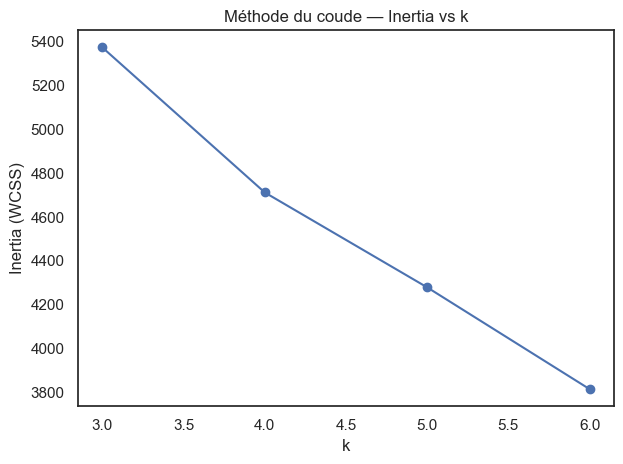

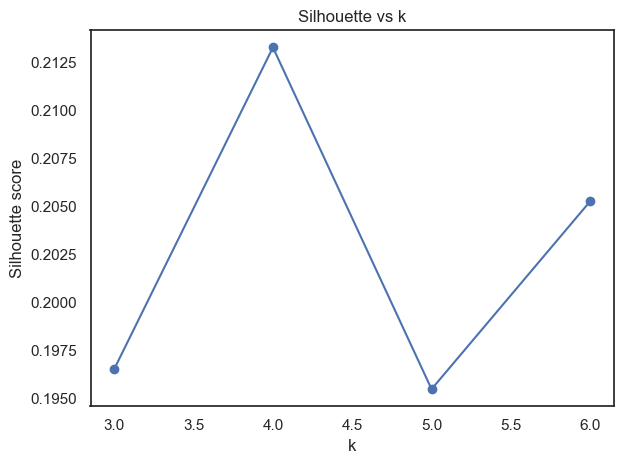

In [27]:
ks = [3, 4, 5, 6]
inertias = []
silhouettes = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

scores = pd.DataFrame({"k": ks, "inertia": inertias, "silhouette": silhouettes})
print(scores)

# Plot coude (inertia)
plt.figure()
plt.plot(scores["k"], scores["inertia"], marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (WCSS)")
plt.title("Méthode du coude — Inertia vs k")
plt.tight_layout()
plt.show()

# Plot silhouette
plt.figure()
plt.plot(scores["k"], scores["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette vs k")
plt.tight_layout()
plt.show()

k_opt proposé (max silhouette): 4


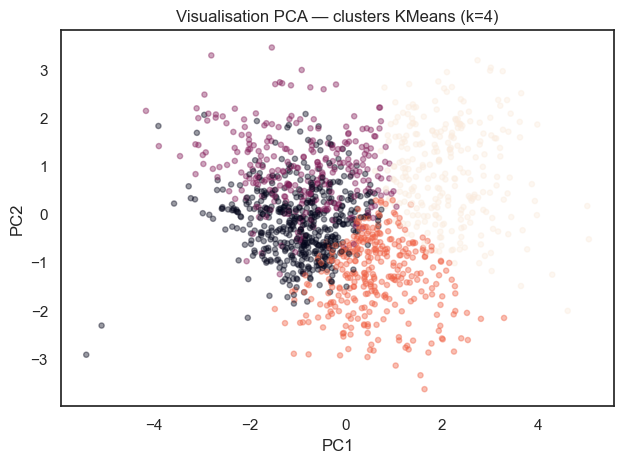

Variance expliquée PCA: [0.36194382 0.22632052] Total: 0.5882643387674076


In [25]:
k_opt = int(scores.sort_values("silhouette", ascending=False).iloc[0]["k"])
print("k_opt proposé (max silhouette):", k_opt)

km_final = KMeans(n_clusters=k_opt, random_state=42, n_init="auto")
d_clust["cluster"] = km_final.fit_predict(X_scaled)

# PCA 2D pour visualisation (sur X_scaled)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
d_clust["PC1"] = X_pca[:, 0]
d_clust["PC2"] = X_pca[:, 1]

plt.figure()
plt.scatter(d_clust["PC1"], d_clust["PC2"], c=d_clust["cluster"], alpha=0.4, s=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Visualisation PCA — clusters KMeans (k={k_opt})")
plt.tight_layout()
plt.show()

print("Variance expliquée PCA:", pca.explained_variance_ratio_, "Total:", pca.explained_variance_ratio_.sum())

In [26]:
# Moyennes des variables (sur l'échelle originale pour interprétation)
# On revient sur d (pas log-transform) pour les moyennes métier
d_profile = d.copy()
d_profile = d_profile.loc[d_clust.index].copy()
d_profile["cluster"] = d_clust["cluster"].values

agg_num = {
    COL_GHG: "mean",
    "GHGIntensity": "mean",
    COL_GFA: "mean",
    COL_YEAR: "mean",
    COL_EUI: "mean",
    COL_ES: "mean",
    COL_ELEC: "mean",
    COL_GAS: "mean"
}

profile_num = d_profile.groupby("cluster").agg(agg_num)
profile_num["n"] = d_profile.groupby("cluster").size()

# Type dominant (mode)
if COL_TYPE in d_profile.columns:
    dominant_type = d_profile.groupby("cluster")[COL_TYPE].agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan)
    profile_num["dominant_type"] = dominant_type

# Tri par taille du cluster
profile_num = profile_num.sort_values("n", ascending=False)
print(profile_num)

         TotalGHGEmissions  GHGIntensity  PropertyGFATotal    YearBuilt  \
cluster                                                                   
0                53.102749      0.001293      46349.990253  1945.945419   
2               142.021569      0.002973      52257.673846  1970.446154   
1                21.459932      0.000367      53837.493151  1954.202055   
3               429.829660      0.001242     359950.279245  1986.539623   

         SiteEUI(kBtu/sf)  ENERGYSTARScore  Electricity(kWh)  \
cluster                                                        
0               43.817544        73.797271      2.794661e+05   
2              123.405231        43.801538      1.019903e+06   
1               39.709932        71.277397      5.401869e+05   
3               82.522642        75.245283      5.060740e+06   

         NaturalGas(therms)    n                dominant_type  
cluster                                                        
0               8218.643624  513  Sm

Le silhouette score est faible pour toutes les valeurs testées (autour de 0.19–0.21), avec un maximum à k=4 (≈ 0.213). Ça veut dire que les clusters existent, mais qu’ils ne sont pas très compacts ni très éloignés les uns des autres dans l’espace des variables standardisées. Le graphe PCA confirme cette lecture : on distingue des zones de densité par couleur, mais il y a un recouvrement important au centre. En revanche, le choix k=4 reste défendable parce qu’il maximise la séparation relative tout en gardant une interprétabilité métier simple.

Sur la caractérisation, k=4 produit des profils bien distincts sur les dimensions clés (taille, intensité énergétique, gaz, électricité), et c’est là que le clustering devient utile : les clusters ne sont pas “purs”, mais ils résument des combinaisons cohérentes.

Le cluster 1 (n=292, type dominant Small- and Mid-Sized Office) se distingue par des émissions totales faibles (≈ 21.46) et surtout une intensité carbone extrêmement basse (≈ 0.000367). Son SiteEUI est bas (≈ 39.7), l’EnergyStar est plutôt élevé (≈ 71.3), l’électricité est modérée et le gaz est quasiment nul (≈ 1.19 therms). Ce profil est celui d’un bâtiment majoritairement électrique ou très peu fossile, avec une signature carbone très faible ; à Seattle, c’est typiquement le groupe “sobre / peu fossilisé”, où même la variabilité d’intensité énergétique ne se convertit pas en émissions.

Le cluster 0 (n=513, type dominant Small- and Mid-Sized Office) ressemble à une version plus “standard fossile léger” : émissions totales modérées (≈ 53.10), intensité carbone plus élevée que le cluster 1 mais encore contenue (≈ 0.001293), SiteEUI autour de 43.8, EnergyStar élevé (≈ 73.8), électricité modérée et gaz clairement présent (≈ 8219 therms). L’année moyenne est plus ancienne (≈ 1946). Ce cluster représente une population large de bâtiments relativement petits/moyens, plutôt anciens, avec une dépendance fossile non négligeable mais pas extrême. C’est un bon exemple de pourquoi Seattle casse les relations simples : un score EnergyStar correct et un EUI modéré peuvent coexister avec des émissions non nulles dès qu’il y a du gaz.

Le cluster 2 (n=325, type dominant Other) est le cluster “énergivore fossile” : SiteEUI très élevé (≈ 123.4), EnergyStar nettement plus bas (≈ 43.8), gaz très élevé (≈ 20260 therms), émissions totales plus hautes (≈ 142.0) et intensité carbone la plus élevée des quatre (≈ 0.002973). La surface moyenne reste du même ordre que les petits/moyens (≈ 52k), donc ici la hausse des émissions n’est pas une histoire de taille : c’est l’intensité et le fossile qui dominent. Ce cluster correspond très bien à un archétype “bâtiments à usage/process ou systèmes inefficaces” qui génèrent beaucoup d’émissions par m².

Le cluster 3 (n=265, type dominant Large Office) est celui des grands ensembles : surface moyenne énorme (≈ 359,950), électricité très élevée (≈ 5.06e6 kWh), gaz le plus élevé (≈ 35,797 therms), SiteEUI assez élevé (≈ 82.5) et surtout des émissions totales très élevées (≈ 429.83). Pourtant, l’intensité carbone n’est pas la pire (≈ 0.001242), elle est même inférieure au cluster 0, et largement inférieure au cluster 2. Cette combinaison est typique d’un archétype “très grand bâtiment” : il émet beaucoup en absolu parce qu’il est gigantesque, mais son intensité carbone n’est pas forcément catastrophique. C’est exactement le genre de régime qui justifie de travailler en parallèle sur `TotalGHGEmissions` et `GHGIntensity` : selon l’objectif (réduction totale vs performance par m²), les priorités d’intervention changent.

Ce que nous pouvons retenir pour la suite est assez clair. D’un côté, le clustering ne révèle pas des frontières nettes, donc je ne recommanderais pas de faire des modèles séparés par cluster comme stratégie principale. De l’autre, les profils sont suffisamment cohérents pour utiliser le cluster comme une feature catégorielle additionnelle, ou comme un outil de diagnostic pour le feature engineering : il te confirme l’existence de régimes “faible fossile”, “fossile intensif”, “très grand”, et “standard ancien fossile modéré”. Le point le plus important est que le cluster 2 (EUI très haut + gaz fort + faible score) et le cluster 3 (très grande taille + émissions absolues énormes) représentent deux types de priorités différentes : l’un est prioritaire pour baisser l’intensité carbone, l’autre pour baisser les émissions totales.

---

# Section 5 : Blueprint de Feature Engineering

L’objectif du feature engineering est de traduire les diagnostics des sections précédentes en variables explicatives robustes, interprétables et utiles pour la modélisation prédictive. Les analyses réalisées ont montré trois points structurants : l’importance dominante de l’échelle (surface) pour les émissions totales, l’existence de régimes conditionnels selon l’usage et l’époque, et surtout le rôle du mix énergétique qui rend l’EUI insuffisant en variable unique dans un contexte où l’électricité est faiblement carbonée. Le blueprint ci-dessous conserve les features qui ont démontré un signal clair, rétrograde celles qui n’ont pas apporté d’information, et propose des alternatives plus “physiques” lorsque la version naïve s’est révélée instable.

## 5.1 Features dérivées simples (base interprétable)

Ces variables structurent le problème et améliorent la stabilité statistique en séparant les effets “échelle” des effets “performance”.

**Age = 2016 − YearBuilt**
Justification : YearBuilt ne produit pas un signal global simple, mais l’âge reste plus interprétable et utile pour capturer des effets de cohorte et de probabilité de rénovation. À utiliser plutôt sous forme de classes (voir Era) ou en interaction par type, car l’effet n’est pas monotone universel.

**Has_ENERGYSTAR (binaire)**
Justification : les facettes ont montré que l’ENERGYSTARScore n’est pas un prédicteur stable globalement, mais l’absence de score peut être informative (données manquantes non aléatoires : petits bâtiments, types spécifiques, reporting incomplet). Le binaire capture cet effet sans sur-interpréter le score.

**Has_Steam (binaire, si SteamUse disponible)**
Justification : à Seattle, la vapeur/district est un facteur carbone structurel. C’est une variable de régime, souvent plus robuste qu’un ratio continu.

**Has_Gas (binaire, si NaturalGas disponible)**
Justification : même logique. Une grande partie du “carbone” est une question de présence fossile.

Remarque importante : certaines variables comme `Footprint_per_floor = GFA / Floors` n’ont pas montré de signal sur l’intensité carbone dans tes résultats (corrélation quasi nulle avec GHGIntensity). Elle peut rester en feature candidate secondaire, mais elle n’est pas prioritaire.

---

## 5.2 Interactions (conserver uniquement celles justifiées par vos tests)

Ici il faut être strict : on garde ce qui a été validé empiriquement, on retire ce qui a été invalidé ou instable.

**Size_Intensity = PropertyGFATotal × SiteEUI**
Justification : c’est la seule interaction “simple” clairement validée. Corrélation très forte avec GHG, stable en log, et l’analyse résiduelle a montré que ce n’est pas uniquement un proxy de la taille. C’est une feature de premier rang pour prédire les émissions absolues.

**Age_ENERGYSTAR = Age × ENERGYSTARScore**
Statut : à retirer comme feature prioritaire.
Justification : ton test a montré une corrélation négative faible et aucune amélioration par rapport aux variables individuelles. Si tu veux la conserver, ce n’est défendable que dans un modèle non linéaire en interaction Type × Score, parce que le seul segment où le score ressort vraiment est Hotel.

**Electricity_Gas_Product = Electricity × NaturalGas**
Statut : non prioritaire en l’état.
Justification : le produit capte surtout l’échelle “double consommation”, mais vos résultats montrent que le ratio mix est très non linéaire et “zero-inflated”. Le produit peut aider un modèle arbre, mais il n’est pas la meilleure feature métier.

---

## 5.3 Features de mix énergétique (à privilégier à Seattle)

Nos tests montrent que le ratio gaz/électricité a une relation monotone (Spearman) mais non linéaire et concentrée près de zéro. Il faut donc des features plus robustes et physiquement interprétables.

**Fossil_Intensity = (Gas_kBtu + Steam_kBtu) / PropertyGFATotal** *(si conversions possibles)*
Justification : c’est la feature la plus directement liée au carbone. Elle sépare les bâtiments à forte charge fossile indépendamment de la taille.

**Fossil_Ratio = (Gas_kBtu + Steam_kBtu) / (TotalEnergy_kBtu + ε)**
Justification : capture la “carbonation du mix”. C’est plus stable qu’un ratio gaz/élec dans des données où beaucoup de bâtiments ont gaz≈0.

**Electrification_Rate = Electricity_kBtu / (TotalEnergy_kBtu + ε)**
Justification : inverse du ratio fossile. Très aligné avec le contexte Seattle.

**Gas_to_Electricity_Ratio = NaturalGas / (Electricity + 1)**
Statut : à garder mais comme feature secondaire, ou en version winsorisée/log, parce que vous avez observé une distribution très concentrée près de 0 avec quelques extrêmes.

---

## 5.4 Features temporelles (validation par facettes)

Nos facettes `log(GHG) vs log(EUI)` par tranches d’âge ont montré que la relation existe partout mais devient plus dispersée dans le bâti récent. Donc le temps doit être codé en régimes.

**Era (catégorielle)** : `<1950`, `1950–1980`, `1980–2000`, `>2000`
Justification : c’est directement aligné sur ton analyse conditionnelle. Era capture les régimes de dispersion et aide le modèle à gérer des relations EUI→GHG moins stables dans les bâtiments récents.

---

## 5.5 Features catégorielles encodées (nécessaires car les pentes changent par type)

L’analyse par facettes `GHG vs GFA` a montré des pentes et des R² très différents selon PrimaryPropertyType. Ça justifie explicitement l’inclusion du type comme feature majeure et l’existence d’interactions implicites dans un modèle non linéaire.

**PrimaryPropertyType**
Justification : variable structurante. Les warehouses ont un comportement très différent des hotels/retail/offices.
Encodage : one-hot si nombre de catégories maîtrisable, sinon regrouper (top N + “Other”).

**Neighborhood**
Justification : le test YearBuilt par quartier n’a pas montré une pente exploitable, mais ça ne signifie pas absence d’effet ; ça signifie que l’effet géographique n’est pas une tendance simple.
Encodage : si beaucoup de quartiers, éviter un one-hot massif : utiliser target encoding (sur train uniquement) ou regrouper top quartiers + “Other”.

**Residential vs NonResidential (binaire)**
Justification : utile pour séparer immédiatement des régimes d’occupation et d’usage.

---

### 5.6 Features issues du clustering (utile comme indicateur de régime)

Ton clustering k=4 a un silhouette faible, donc ce n’est pas une segmentation “naturelle” parfaite, mais les profils sont interprétables et discriminants (faible fossile, fossile intensif, très grand bâtiment, etc.). Cela justifie d’utiliser l’appartenance au cluster comme feature de régime, pas comme vérité absolue.

**Cluster_ID (catégorielle) + one-hot clusters**
Justification : permet au modèle de basculer rapidement entre comportements typiques : petits bâtiments quasi sans gaz, bâtiments énergivores fossiles, grands bureaux très émetteurs en absolu mais pas forcément en intensité.

---

### 5.7 Features spatiales

**Is_Downtown**
Justification : à Seattle, c’est souvent un proxy du district steam / gros tertiaire. À utiliser seulement si Neighborhood est fiable et si Downtown est assez représenté. C’est une feature métier simple qui peut capter un effet d’infrastructure.

---
## 5.8 Tableau décisionnel (base finale)

| Variable                              | Décision                    | Pourquoi                                                                   | Notes / utilisation                                                        |
| ------------------------------------- | --------------------------- | -------------------------------------------------------------------------- | -------------------------------------------------------------------------- |
| **OSEBuildingID**                     | DROP                        | ID pur → n’apporte pas d’info causale, risque d’overfit                    | À garder seulement pour joindre/traçabilité, pas en features               |
| **PropertyName**                      | DROP                        | Texte “nominal” (forte cardinalité), bruit, fuite possible via noms connus | Tu peux extraire un “has_number/has_center” mais souvent inutile           |
| **TaxParcelIdentificationNumber**     | DROP                        | Identifiant fiscal → ID déguisé                                            | Même logique que BuildingID                                                |
| **Address**                           | DROP                        | Trop spécifique (ID déguisé), high cardinality                             | Si tu veux du spatial : utilise lat/long ou distance_center                |
| **City**                              | DROP                        | Constant (Seattle) → zéro signal                                           |                                                                            |
| **State**                             | DROP                        | Constant (WA)                                                              |                                                                            |
| **ZipCode**                           | MAYBE                       | Peut capturer socio-urbain / densité / réseau vapeur                       | Si trop de modalités : regrouper (top N + Other) ou target encoding OOF    |
| **CouncilDistrictCode**               | KEEP (léger)                | Proxy géographique + politique urbaine                                     | Peu de catégories → one-hot ok                                             |
| **Neighborhood**                      | KEEP                        | Effets de régime (downtown/steam/typologie urbaine)                        | Cardinalité modérée → one-hot / target encoding OOF                        |
| **Latitude / Longitude**              | KEEP (ou transformer)       | Spatial continu souvent utile                                              | Mieux : créer `distance_to_center` + éventuellement clusters géographiques |
| **DataYear**                          | DROP                        | Constant (2016)                                                            | Si multi-années un jour → keep                                             |
| **YearBuilt**                         | KEEP (transform)            | Effet “cohorte”/rénovation                                                 | Transformer en `Age` + `Era` (bins)                                        |
| **NumberofBuildings**                 | KEEP                        | Effet taille/site multi-bâtiment                                           | Souvent lié à énergie totale                                               |
| **NumberofFloors**                    | MAYBE                       | Signal parfois bruité / manquant                                           | Peut aider (verticalité), sinon drop si qualité faible                     |
| **PropertyGFATotal**                  | KEEP (CORE)                 | Feature la plus structurante pour GHG total                                | Ajouter `log_GFA`                                                          |
| **PropertyGFABuilding(s)**            | MAYBE                       | Très corrélé à GFATotal                                                    | Garde **soit** GFATotal **soit** GFABuilding(s) (+ parking séparé)         |
| **PropertyGFAParking**                | MAYBE                       | Signal “parking = usage” + taille non chauffée                             | Peut aider; aussi utile pour `Has_Parking`                                 |
| **BuildingType**                      | KEEP                        | Régimes (Campus vs NonResidential vs Residential etc.)                     | One-hot                                                                    |
| **PrimaryPropertyType**               | KEEP (CORE)                 | Régime majeur (pentes différentes)                                         | One-hot ou top N + Other                                                   |
| **ListOfAllPropertyUseTypes**         | DROP                        | Texte multi-label sale → trop de bruit                                     | Tu peux dériver `nb_use_types` si tu veux, sinon drop                      |
| **LargestPropertyUseType**            | MAYBE                       | Peut être redondant avec PrimaryPropertyType                               | Utile si PrimaryPropertyType est trop “broad”                              |
| **LargestPropertyUseTypeGFA**         | KEEP (si dispo)             | Taille du “main use” aide beaucoup                                         | Très bon signal empirique (souvent top features)                           |
| **SecondLargestPropertyUseType**      | MAYBE                       | Ajoute info “mixed-use”                                                    | À garder si peu de NA + encodage gérable                                   |
| **SecondLargestPropertyUseTypeGFA**   | MAYBE                       | Mesure de mixité (2e usage)                                                | Tu peux aussi créer `mix_ratio = SecondGFA / TotalGFA`                     |
| **ThirdLargestPropertyUseType / GFA** | DROP ou MAYBE               | Souvent très manquant + faible gain                                        | Garde seulement si tes NA ne explosent pas                                 |
| **ENERGYSTARScore**                   | MAYBE                       | Signal non stable globalement, mais utile par segments                     | À tester; sinon utiliser surtout `Has_ENERGYSTAR`                          |
| **YearsENERGYSTARCertified**          | DROP                        | Texte/historique difficile, manquant                                       | Tu peux en dériver `is_certified_any` (binaire) si rempli                  |
| **SiteEUI(kBtu/sf)**                  | KEEP (CORE)                 | Performance énergétique normalisée surface                                 | Très utile, mais pas suffisant seul (mix)                                  |
| **SiteEUIWN(kBtu/sf)**                | MAYBE                       | Redondant avec SiteEUI                                                     | Garde WN si tu choisis WN partout (cohérence)                              |
| **SourceEUI(kBtu/sf)**                | MAYBE                       | Peut ajouter effet “pertes réseau”                                         | Souvent corrélé → en choisir 1 ou 2 max                                    |
| **SourceEUIWN(kBtu/sf)**              | DROP/MAYBE                  | Très redondant                                                             | Trop de variantes EUI = multicolinéarité                                   |
| **SiteEnergyUse(kBtu)**               | KEEP (CORE)                 | Énergie totale brute → très prédictif de GHG total                         | Attention : très corrélé à GFA*EUI (normal)                                |
| **SiteEnergyUseWN(kBtu)**             | MAYBE                       | Redondant avec SiteEnergyUse                                               | Pareil que WN                                                              |
| **Electricity(kWh)**                  | DROP (si kBtu dispo)        | Doublon d’unité (kWh vs kBtu)                                              | Garde kBtu pour cohérence énergétique                                      |
| **Electricity(kBtu)**                 | KEEP                        | Composante mix électrique                                                  |                                                                            |
| **NaturalGas(therms)**                | DROP (si kBtu dispo)        | Doublon unité                                                              |                                                                            |
| **NaturalGas(kBtu)**                  | KEEP                        | Composante fossile principale                                              | + `Has_Gas` binaire                                                        |
| **SteamUse(kBtu)**                    | KEEP                        | Seattle : variable de régime carbone (district steam)                      | + `Has_Steam`                                                              |
| **TotalGHGEmissions**                 | TARGET                      | Cible                                                                      | À sortir de X                                                              |
| **GHGEmissionsIntensity**             | DROP (leakage)              | C’est littéralement target / GFA (ou dérivé direct)                        | Interdit en features si target = TotalGHGEmissions                         |
| **DefaultData**                       | MAYBE                       | Indicateur qualité / valeurs imputées                                      | Souvent utile pour corriger biais des NA                                   |
| **ComplianceStatus**                  | DROP/MAYBE                  | Peut être corrélé à reporting plus qu’au physique                          | Si tu fais prédiction “hors contexte règlementaire”, drop                  |
| **Outlier**                           | KEEP (si défini proprement) | Flag qualité utile (mais attention : peut cacher traitement déjà fait)     | Souvent à utiliser pour filtrer train, pas comme feature                   |
| **Comments**                          | DROP                        | Texte peu rempli                                                           |                                                                            |

---

In [ ]:
df_fe = feature_engineering.feature_engineering_seattle(df, cfg)

✓ Feature engineering sauvegarde dans : D:\Machine Learning 1\Projet\Project folder\ML-prediction-CO2\data\proceed\feature_engineered.csv
